In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.executable

'/data/env/bin/python3.6'

In [3]:
from sensitivity_tests import *

import matplotlib.pyplot as plt
from tqdm import tqdm
from pathlib import Path
import os
import numpy as np
import math
import random
import sys
import itertools
from scipy import stats
import pandas as pd
from pyrankability_dev.rank import *
#import pyrankability

from gurobipy import *
setParam("OutputFlag", 0)
setParam("Presolve", 0)

Academic license - for non-commercial use only


In [4]:
# Produces a pandas Series with the optimal rankings found from each permutation
def solve_all_permutations(D_orig):
    perms = list(itertools.permutations(range(D_orig.shape[0])))
    P_elems = []
    for perm in tqdm(perms):
        D_permuted = D_orig[perm,:][:,perm]
        k, details = solve(D_permuted)
        #k, details = pyrankability.lop.bilp(D_permuted)
        elem = list(details["P"][0])
        for i in range(len(elem)):
            elem[i] = perm[elem[i]]
        P_elems.append(str(elem))
    return pd.Series(P_elems)

# Checks if the frequencies are uniform or not
def check_freqs(freqs):
    if len(freqs.unique()) > 1:
        print(freqs)
        plt.bar(range(1, len(freqs)+1), height=freqs.values)
        plt.show()
        return False
    else:
        print("Perfectly balanced, as all things should be.")
        print("All {0} elements produced by {1} permutations".format(len(freqs), freqs.unique()[0]), flush=True)
        return True  

# Generates random noisy D matrices and checks for uniform frequency
def test_rand_D(noise_gen, num_attempts):
    for i in range(num_attempts):
        D2 = noise_gen.apply_noise(D)
        print(D2)
        P_elems_series = solve_all_permutations(D2)
        freqs = P_elems_series.value_counts()
        check_freqs(freqs)

def test_rand_D_correlate_sensitivity(noise_gen, num_attempts):
    for i in range(num_attempts):
        D2 = noise_gen.apply_noise(D)
        print(D2)
        P_elems_series = solve_all_permutations(D2)
        freqs = P_elems_series.value_counts()
        if not check_freqs(freqs):
            D2_P = pd.Series(freqs.index.values)
            D2_P_counts = D2_P.copy(deep=True)
            D2_P_counts.loc[:] = 0
            noise_gen2 = BinaryFlipNoise(0.05)
            # Try 20 at a time and plot
            for j in range(5):
                for k in range(20):
                    D3 = noise_gen2.apply_noise(D2)
                    D3_P = solve_all_permutations(D3).unique()
                    D2_P_counts = D2_P_counts.add(D2_P.isin(D3_P).astype(int))
                plt.bar(range(1, len(D2_P_counts)+1), height=D2_P_counts.values)
                plt.show()

## Perfect Dominance with Constant # of Ties

In [5]:
n_items = 7
n_ties = 4

# Create perfect binary dominance
D = PerfectBinarySource(n_items).init_D()

# Tie-up the bottom n_ties items
for i in range(n_ties):
    D[n_items-i-1] = 0

D

array([[0, 1, 1, 1, 1, 1, 1],
       [0, 0, 1, 1, 1, 1, 1],
       [0, 0, 0, 1, 1, 1, 1],
       [0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0]])

100%|██████████| 5040/5040 [00:22<00:00, 226.59it/s]

Perfectly balanced, as all things should be.
All 24 elements produced by 210 permutations


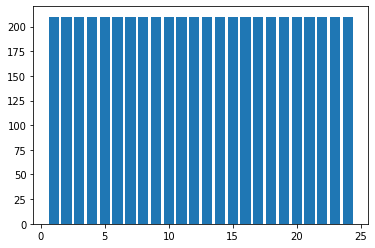

In [6]:
n_ties_series = solve_all_permutations(D)
freqs = n_ties_series.value_counts()
check_freqs(freqs)
plt.bar(range(1, len(freqs)+1), height=freqs.values)
plt.show()

## Re-initialize D

In [7]:
D = PerfectBinarySource(n_items).init_D()
D

array([[0, 1, 1, 1, 1, 1, 1],
       [0, 0, 1, 1, 1, 1, 1],
       [0, 0, 0, 1, 1, 1, 1],
       [0, 0, 0, 0, 1, 1, 1],
       [0, 0, 0, 0, 0, 1, 1],
       [0, 0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 0, 0]])

## Swap Noise

In [8]:
test_rand_D(SwapNoise(0.5), 4)

  0%|          | 20/5040 [00:00<00:25, 195.38it/s]

[[0 1 1 1 0 0 0]
 [0 0 1 0 1 1 1]
 [0 0 0 0 0 1 0]
 [0 1 1 0 1 1 0]
 [1 0 1 0 0 0 0]
 [1 0 0 0 1 0 1]
 [1 0 1 1 1 0 0]]


100%|██████████| 5040/5040 [00:25<00:00, 195.18it/s]

Perfectly balanced, as all things should be.
All 12 elements produced by 420 permutations



  0%|          | 21/5040 [00:00<00:24, 204.41it/s]

[[0 1 0 1 0 1 1]
 [0 0 0 1 1 0 0]
 [1 1 0 0 1 1 0]
 [0 0 1 0 0 1 0]
 [1 0 0 1 0 0 1]
 [0 1 0 0 1 0 1]
 [0 1 1 1 0 0 0]]


100%|██████████| 5040/5040 [00:26<00:00, 186.97it/s]

Perfectly balanced, as all things should be.
All 24 elements produced by 210 permutations



  0%|          | 20/5040 [00:00<00:26, 191.02it/s]

[[0 1 1 0 1 1 1]
 [0 0 0 0 1 1 0]
 [0 1 0 0 0 0 0]
 [1 1 1 0 1 1 1]
 [0 0 1 0 0 0 0]
 [0 0 1 0 1 0 1]
 [0 1 1 0 1 0 0]]


100%|██████████| 5040/5040 [00:26<00:00, 190.57it/s]

Perfectly balanced, as all things should be.
All 4 elements produced by 1260 permutations



  0%|          | 22/5040 [00:00<00:23, 213.31it/s]

[[0 0 1 1 0 1 0]
 [1 0 0 0 1 1 1]
 [0 1 0 0 1 1 0]
 [0 1 1 0 1 0 0]
 [1 0 0 0 0 0 1]
 [0 0 0 1 1 0 1]
 [1 0 1 1 0 0 0]]


100%|██████████| 5040/5040 [00:25<00:00, 197.64it/s]

Perfectly balanced, as all things should be.
All 120 elements produced by 42 permutations


## Binary Flip Noise

In [9]:
#test_rand_D(BinaryFlipNoise(0.5), 4)
test_rand_D_correlate_sensitivity(BinaryFlipNoise(0.5), 4)

  0%|          | 22/5040 [00:00<00:22, 218.28it/s]

[[0 1 1 1 0 1 0]
 [0 0 0 1 0 0 1]
 [0 0 0 1 0 0 1]
 [1 1 0 0 1 1 1]
 [1 1 0 0 0 0 1]
 [1 1 1 0 0 0 0]
 [0 1 1 1 1 1 0]]


100%|██████████| 5040/5040 [00:25<00:00, 197.74it/s]

Perfectly balanced, as all things should be.
All 24 elements produced by 210 permutations



  0%|          | 20/5040 [00:00<00:25, 197.56it/s]

[[0 1 0 1 0 1 0]
 [1 0 1 1 0 0 1]
 [1 0 0 0 0 0 1]
 [1 1 1 0 0 0 1]
 [1 0 0 0 0 1 0]
 [0 0 1 0 0 0 0]
 [1 1 0 0 0 0 0]]


100%|██████████| 5040/5040 [00:25<00:00, 199.23it/s]

Perfectly balanced, as all things should be.
All 12 elements produced by 420 permutations



  0%|          | 19/5040 [00:00<00:27, 180.48it/s]

[[0 0 1 0 0 1 0]
 [0 0 0 1 0 0 1]
 [0 1 0 0 1 1 0]
 [1 0 0 0 1 1 1]
 [0 1 0 0 0 0 1]
 [1 0 1 1 0 0 1]
 [0 1 1 1 1 1 0]]


100%|██████████| 5040/5040 [00:26<00:00, 193.08it/s]

Perfectly balanced, as all things should be.
All 24 elements produced by 210 permutations



  0%|          | 19/5040 [00:00<00:26, 189.43it/s]

[[0 1 1 0 0 1 0]
 [1 0 0 0 0 0 0]
 [1 0 0 1 1 0 1]
 [1 0 1 0 1 0 0]
 [1 0 0 0 0 1 1]
 [0 0 0 1 1 0 1]
 [0 0 1 1 1 0 0]]


100%|██████████| 5040/5040 [00:26<00:00, 188.70it/s]

Perfectly balanced, as all things should be.
All 24 elements produced by 210 permutations


## Normal Resampling Noise

In [10]:
test_rand_D(NormalResamplingNoise(0.5), 4)

  0%|          | 22/5040 [00:00<00:23, 212.43it/s]

[[0 1 1 0 0 0 0]
 [0 0 1 1 1 1 0]
 [0 0 0 1 1 1 1]
 [0 0 0 0 1 1 0]
 [0 0 0 0 0 1 0]
 [0 0 1 0 0 0 0]
 [0 0 0 0 0 0 0]]


100%|██████████| 5040/5040 [00:25<00:00, 199.70it/s]

Perfectly balanced, as all things should be.
All 1 elements produced by 5040 permutations



  0%|          | 17/5040 [00:00<00:29, 169.10it/s]

[[0 1 1 0 1 0 1]
 [1 0 1 0 0 0 0]
 [0 0 0 1 0 1 1]
 [1 0 0 0 1 1 1]
 [0 0 0 0 0 1 1]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]]


100%|██████████| 5040/5040 [00:25<00:00, 195.65it/s]

Perfectly balanced, as all things should be.
All 2 elements produced by 2520 permutations



  0%|          | 21/5040 [00:00<00:24, 204.62it/s]

[[0 1 1 0 1 0 0]
 [0 0 0 1 0 0 1]
 [0 0 0 1 1 1 1]
 [0 0 1 0 1 1 0]
 [0 0 0 0 0 1 0]
 [0 0 0 0 0 0 1]
 [0 0 0 0 1 0 0]]


100%|██████████| 5040/5040 [00:26<00:00, 192.17it/s]

Perfectly balanced, as all things should be.
All 4 elements produced by 1260 permutations



  0%|          | 19/5040 [00:00<00:27, 185.69it/s]

[[0 1 1 1 1 1 0]
 [0 0 0 1 0 0 1]
 [0 0 0 0 1 0 0]
 [0 1 0 0 0 1 0]
 [0 0 0 0 0 1 1]
 [0 1 0 0 0 0 1]
 [0 0 0 0 0 0 0]]


100%|██████████| 5040/5040 [00:26<00:00, 187.43it/s]

Perfectly balanced, as all things should be.
All 12 elements produced by 420 permutations
